In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    RandomizedSearchCV,
)

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
487518,1160644444821045249,este gajo é tão triste 😐,-0.392593,-1
10715,1559742354998890498,eu e eu defendendo o trio odiado do masterchef...,0.693460,1
731525,1161001691468247041,🗝️ | . . » outro projeto que nos emocionou mui...,0.746087,1
760094,1161052060500013057,manda foto do pezinho 😍,0.677937,1
892295,1161377066870280194,parabéns ❤,0.746087,1
743526,1161021566018347010,vô mentir não mano tô triste pra caralho tá do...,-0.093377,-1
870671,1161317193658900480,agora sim um coach que preste! 😝,0.425403,1
343769,1559980614526328838,hahahaa melhor colocar estas línguas afiadas p...,0.395872,1
630890,1160857033794555904,minha conta voltou ao normal ✨,0.352594,1
379343,1559994723540033541,a la próxima será 💓,0.671815,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

40        está
157     seriam
0            a
7      aqueles
174      tenho
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: meu pé tá engessado mesmo assim to sentindo uma dor absurda 😥

Tweet Limpo   : pé tá engessado assim to sentindo dor absurda

Tweet Stemed  : pé tá engess assim to sent dor absurd


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
326627,1559968020507893760,seus pais n assinavam os termos tudo pra vc???...,0.411765,1,pal n assin term tud pra vc hhaahhah pq uma pá...
850395,1161269537087610881,eita 😅,0.179654,0,eit
191574,1559894693206532097,boa tarde 😘😘,1.403509,1,boa tard
691911,1160942340003041282,claro que sim 👍,0.522114,1,clar sim
137099,1559870123007262722,vou atrás dessa divisão do trabalho e o livre ...,0.260664,1,vou atrás dess divis trabalh livr merc caus pe...


# Engenharia de Atributos: Soma das Frequencias

Este modelo é extremamente simples.

Vamos transformar o texto numa representação vetorial utilizando o somatório da frequencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

In [11]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [12]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

Chaves: 58366


In [13]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

Chaves: 27524


In [14]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

Chaves: 32001


### Visualização dos Dicionários

In [15]:
dicionarios = pd.DataFrame(
    [
        pd.Series(dicionario_positivo, name="positivo"),
        pd.Series(dicionario_neutro, name="neutro"),
        pd.Series(dicionario_negativo, name="negativo"),
    ]
).T

In [16]:
dicionarios.sample(10)

,positivo,neutro,negativo
preciosa,2.0,NaN,NaN
hahahaahahah,4.0,1.0,1.0
zlxmdzkdk,1.0,NaN,NaN
lynch,1.0,NaN,1.0
aneemm,1.0,NaN,NaN
tiw,1.0,NaN,1.0
martinaa,1.0,NaN,NaN
katherin,2.0,NaN,NaN
vrauuu,4.0,NaN,NaN
stablishmant,NaN,1.0,NaN


## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [17]:
def gerar_feature_vector(
    string, dicionario_positivo, dicionario_neutro, dicionario_negativo
):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([dicionario_positivo.get(word, 0) for word in tokens])
    feature_neutra = sum([dicionario_neutro.get(word, 0) for word in tokens])
    feature_negativa = sum([dicionario_negativo.get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [18]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(
    tweet, dicionario_positivo, dicionario_neutro, dicionario_negativo
)

print("Tweet: {}".format(tweet))
feature_vector

Tweet: gat faz n


positiva    21821
neutra       6372
negativa    14508
dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [19]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_train["label"] = X_train["label"]

In [20]:
features_train.sample(5)

,positiva,neutra,negativa,label
759905,23770,6801,17824,-1
413611,2988,1050,1112,1
403591,56066,5161,12863,1
156388,27119,8075,16004,-1
35787,10190,2297,4222,1


In [21]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

,positiva,neutra,negativa
116219,8594,1930,2220
445370,10449,2570,3747
582407,9197,2692,6177
111293,23503,8714,13824
112134,37848,9098,26805


In [22]:
y_features_train = features_train["label"]
y_features_train.sample(5)

221606   -1
336734    1
801552   -1
508335   -1
852223   -1
Name: label, dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [23]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_test["label"] = X_test["label"]

In [24]:
features_test.sample(5)

,positiva,neutra,negativa,label
394049,11334,3362,6550,-1
326662,19085,3746,7968,1
315738,21788,938,2834,1
636616,72165,20977,42063,0
317056,74339,18650,37656,1


In [25]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

,positiva,neutra,negativa
330435,92608,24973,47710
677420,12377,3494,10764
444152,29531,2803,7019
695979,3370,1208,2722
135809,23309,956,2936


In [26]:
y_features_test = features_test["label"]
y_features_test.sample(5)

47295    -1
760211    1
107695    1
379001    0
636265    1
Name: label, dtype: int64

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [27]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler()

In [28]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

,positiva,neutra,negativa
579184,3.476537,3.290389,2.974275
153056,-0.845037,-0.905079,-0.902274
181400,-0.886442,-0.832999,-0.837732
622498,-0.046655,-0.637722,-0.523748
222082,0.696655,0.904981,1.260151


In [29]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

,positiva,neutra,negativa
30864,2.094661,2.440750,2.818881
123852,0.019586,0.001161,-0.536249
180215,-0.723503,-0.639012,-0.650504
81839,-0.926341,-0.902015,-0.890499
212286,0.540844,0.445895,-0.078863


# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [30]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 8.41%


In [31]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 14.25%


In [32]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 24.57%


In [33]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 24.57%


## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [34]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [35]:
params = {
    "C": np.linspace(0.5, 2, 100),
    "tol": np.linspace(1e-5, 1e-3, 100),
}

clf = RandomizedSearchCV(log, params, scoring="f1_macro", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 35.62%


In [36]:
clf.best_params_

{'tol': 0.00022999999999999998, 'C': 1.7575757575757576}

In [37]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [38]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 24.57%
Score Modelo   : 35.62%
Diferença      : 11.05%


### Performance no Conjunto de Treino

In [39]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 35.62%


### Curva de Aprendizado

In [40]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

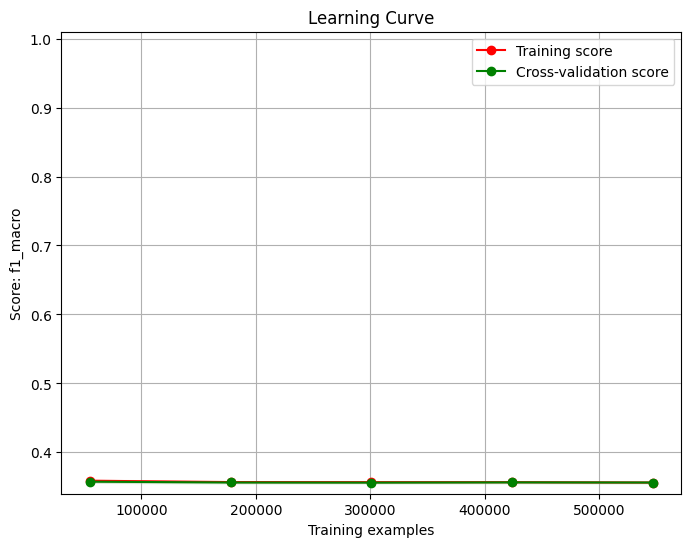

In [41]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Histogram-Based Gradient Boosting

Referências:
- [https://en.wikipedia.org/wiki/Gradient_boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

In [42]:
hgb = HistGradientBoostingClassifier(
    tol=0.00024,
    min_samples_leaf=5,
    learning_rate=0.74,
    random_state=42,
)

In [43]:
s1 = time()
scores = cross_val_score(
    hgb, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
hgb_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(hgb_score * 100))

Elapsed Time:  6 seconds
F-Score: 42.66%


In [44]:
hgb.fit(X_features_train_scaled, y_features_train)

HistGradientBoostingClassifier(learning_rate=0.74, min_samples_leaf=5,
                               random_state=42, tol=0.00024)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [45]:
# hgb = HistGradientBoostingClassifier(random_state = 42)
# params = {
#    "learning_rate": np.linspace(0.01, 1, 20),
#    "tol": np.linspace(1e-5, 1e-3, 100),
#    'min_samples_leaf': [x for x in range(1,11)],
# }
#
# clf = RandomizedSearchCV(hgb, params, scoring='f1_macro', random_state=42)
# clf.fit(X_features_train_scaled, y_features_train)
#
# print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [46]:
# clf.best_params_
print(
    {
        "tol": 0.00023999999999999998,
        "min_samples_leaf": 5,
        "learning_rate": 0.7394736842105263,
    }
)

{'tol': 0.00023999999999999998, 'min_samples_leaf': 5, 'learning_rate': 0.7394736842105263}


In [47]:
# hgb = clf.best_estimator_

#### Comparação com Métrica base

In [48]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(hgb_score * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - hgb_score) * 100))

Score Baseline : 24.57%
Score Modelo   : 42.66%
Diferença      : 18.09%


### Performance no Conjunto de Treino

In [49]:
y_pred = hgb.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 42.85%


### Curva de Aprendizado

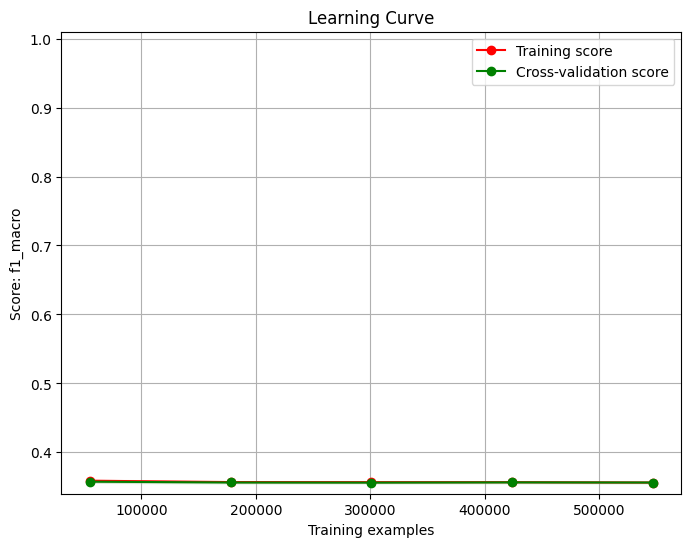

In [50]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Validação em conjunto de Teste

In [51]:
y_pred = hgb.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 41.61%


### Preditos Positivos

In [52]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [53]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['uma line boa que não deu certo 😔',
       'para o united??? mantenham no preso sff 😭', 'tá em % 😭',
       'pode me explicando isso agora 😡', 'eu tô notando isso mesmo! 😞',
       'inclusive todos lindos no vídeo 😔😔 queria dar um beijinho na testa de cada um',
       'que coisa 💔',
       'ai *qualquer divindade* tira esse problema de confiar do meu coração 😭',
       'tentei. 😭',
       'chegou aquele tesão de madrugada😖🤧 like: foto do pau🍆 rt: foto da bunda🍑'],
      dtype=object)

#### Falso Positivo -> Neutro

In [54]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['maceta msm miga 🔥',
       'é verdade n compra felicidade mas com certeza ajuda 😂',
       'pros rolê de eletrônica num chama nunca né 😢',
       'ela passando a mão na minha perna e eu quase tendo um treco &gt;&gt;&gt;😥',
       'que felicidade saber do seu apoio, companheira! estamos juntos! 👊⭐️',
       'e o meu pai que pergunta se eu já fui no ginecologista fazer prevenção 😂',
       'globoludos!!! 😂', 'more like estou a beber mijo 😂',
       'impossível controlar kkk 🌚🔥',
       'vamos aprender pra meter na galele 😂'], dtype=object)

#### Verdadeiro Positivo

In [55]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['feliz aniversário leo!! tudo de bom para ti 💜💜💜☺️',
       'dia triste e estressante 👍',
       'fav: 😜: primeira impressão: fofinha 🤓: nível de proximidade - : ✨: uma mensagem…',
       'eu amo a * e ninguém liga 🙏', 'cú gostoso 😋 tezão pegar de',
       'ano q vem tudo melhora 👍',
       'meses pro ano acabar, o que eu ja fiz: 👫 sim 💏 não 👩\u200d❤\u200d💋\u200d👩 não 😬 todo dia 😈 nunca msm 👅 puts 🤭 sim 🤐 credo nã…',
       'a cafonice do ser humano não tem limites...😁',
       'eu e o bryce conta de besties💕 te amo', 'accha ☺️'], dtype=object)

### Preditos Negativos

In [56]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [57]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['mas duas pela manhã 💖',
       'se bater saudade espero que entenda que meu paraíso tem nós dois a sós 🎶',
       'tô olhando o filme q eu gosto 😍',
       'uma hora dessas e eu sentada no chão do banheiro chorando de tanta cólica 👍',
       'assistir friends é tão 🥰🤍💖✨😅🥺', 'na cara dele não mano 😂😂',
       'comi dms agr, ave. tô ficando craque no arroz recheado 😍 (mas essa mania de comer besteira essa hr vai acabar, fé 🤞🏽',
       'o gente que ela dorme é diferente 😍',
       'o globo com crise de sincericidio! 😂😂😂', 'ih, nao tinha visto 😊'],
      dtype=object)

#### Falso Negativo -> Neutro

In [58]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['queria um abraço seu 😥', 'to nessa 😅',
       'o que eu chorei com a reportagem do esporte espetacular do biel e o pai dele foi brincadeira viu... 😢',
       'a legenda estranha é provavelmente a letra da música water do schoolboy q 😂',
       'acordei as : da manha pra correr,tô me sentindo até leve 😅',
       'chega logo outubro. quero minhas férias!!! 😢', '$noia 🔥🚀',
       'não consigo ver o tweet 😰',
       'o lucão, viu sobre o acidente na rússia? tão dizendo q foi nuclear, porém mais complexo do q estão informando. 😱',
       'fui com o golf da minha irmã p meu avô hoje e só sei dizer uma coisa.. me matar de trabalhar p ter um daquele 😂'],
      dtype=object)

#### Verdadeiro Negativo

In [59]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['odeio ver minha pretinha dodói 😔', 'só queria um açaí agr 😓',
       'vou dormir mais 😴', 'so nega 😤',
       'boa noite me perdoa pela humilhação mas se puder me ajudar serei eternamente agradecida muito obrigada de coração e que deus abençoe grandemente 😭',
       'saudades de comer algo que eu possa mastigar 😪',
       'e acabou outra série 😞', 'poxa só queria uma promoção da 💔',
       'queria ter uma mina pra chamar de minha 😓',
       'era só um almoço no shoppping agr , querer ñ é poder né. 😑'],
      dtype=object)

### Preditos Neutros

In [60]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [61]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['hoje fui no extra comprar pão e um cara me olhou e eu olhei pra ele e do nada o pau ficou duro na hora 🙈🙈🙈 mano ja tinha tempo q eu nao sentia isso em alguem, so de olhar e o pau subir sem ser em um ambiente de sexo ou festa 😈😈😈🔥🔥🔥',
       'alguém me dá folhas de polipropileno por favor ✊',
       'e o medo de andar na calçada? 🤣🤣🤣ihuuu💚🇧🇷💙',
       'vcs n prestam kkk ele no começo da temporada "não, pq somos dois homens" "mas pq será q eu me sinto tão atraído por ele, sendo q ele é homem?" ele agora: não, então, eu até já me preparei, eu realmente quero kkk muito fofos tá💕',
       'bom dia, que esse dia seja intenso, produtivo, e que saibamos aproveitar cada segundo dele. bora ser feliz né 🌻❤',
       'me asf 😂😂😂', 'faberry. ❤',
       'chuva de arroz pra eternizar, juras a dois pra eternizar, gravata e véu pra eternizar, ouro e anel pra eternizar 🎶',
       'vc é demais madrinha 👏', 'sem medooo 💚💚💚'], dtype=object)

#### Falso Neutro -> Negativo

In [62]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['eu não namoro por que ninguém me quer já usei tanto essa frase q o corretor já até sabe kkk 😭',
       'não tem nem vergonha 💀', 'deus usa lula e bolsonaro usa deus 😭',
       'cadê minha mãe 😩',
       '[ / / : : ] silvio : kskskakakaksksks milene tá em uma loucura segura viu pcr [ / / : : ] camila: vai doida kkk [ / / : : ] roni: mmkmmmkkkq onda do carai ngm entende nd q eu falo😭',
       'nem eu, nunca foi meta pra depois se acabar todo de estudar só pra falar que estuda na usp 😒 muito esforço pra pouca coisa',
       'kkk absurdo 😡', 'não tenho facebook. 😭😭😭', 'me rindo😔',
       'me rindo 😔'], dtype=object)

#### Verdadeiro Neutro

In [63]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['muito funkeira 😂', 'fredo 😂',
       'tô rindo muito com marcelo kkk que fdp cara, peste garoto eu caí ficou eu e ele rindo pra crlh meu pé tá doendo 😂🤡',
       'fogo 🔥',
       'indireta ela joga,agora pergunta se consegue jogar o cabelo kkk😂',
       'eitaaa👀👀👀', 'qesme 😂', 'kkk esse cara é hilário 😂',
       'é fixe olhares para os comentários e ver que ninguem fala em salarios 😅. só é preciso comprar, pagar o salário fica para a segurança social',
       'eita 😳'], dtype=object)